<a href="https://colab.research.google.com/github/taniasahu/Automatic-Modulation-Classification-/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow -q
!pip install numpy -q
!pip install scipy -q
!pip install keras -q
!pip install matplotlib -q
!pip install scikit-learn -q
!pip install seaborn -q

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to file location in Google Drive
file_path = '/content/drive/My Drive/AMC_dataset.mat'

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from scipy.io import loadmat
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define modTypes
modTypes = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM", "GFSK", "CPFSK", "PAM4", "B-FM", "DSB-AM", "SSB-AM"]

# Load dataset
mat = loadmat(file_path)
data = mat['data'].astype(np.float32)
labels = mat['labels'].flatten().astype(np.uint8)
split = mat['split'].flatten().astype(np.uint8)

# Split data in I/Q form
train_idx = np.where(split == 0)[0]
val_idx = np.where(split == 1)[0]
test_idx = np.where(split == 2)[0]

X_train_iq = data[train_idx]  # Shape: (num_train, 1024, 2)
y_train = labels[train_idx] - 1  # Convert 1-based to 0-based
X_val_iq = data[val_idx]
y_val = labels[val_idx] - 1
X_test_iq = data[test_idx]
y_test = labels[test_idx] - 1

# Convert I/Q to polar form
def iq_to_polar(iq_data):
    I = iq_data[:, :, 0]
    Q = iq_data[:, :, 1]
    amplitude = np.sqrt(I**2 + Q**2)
    phase = np.arctan2(Q, I)
    return np.stack([amplitude, phase], axis=-1)

X_train = iq_to_polar(X_train_iq)  # Shape: (num_train, 1024, 2)
X_val = iq_to_polar(X_val_iq)
X_test = iq_to_polar(X_test_iq)

# Normalize amplitude using training set statistics
amplitude_mean = np.mean(X_train[:, :, 0])
amplitude_std = np.std(X_train[:, :, 0])
X_train[:, :, 0] = (X_train[:, :, 0] - amplitude_mean) / (amplitude_std + 1e-10)
X_val[:, :, 0] = (X_val[:, :, 0] - amplitude_mean) / (amplitude_std + 1e-10)
X_test[:, :, 0] = (X_test[:, :, 0] - amplitude_mean) / (amplitude_std + 1e-10)

# One-hot encode labels
num_classes = 11
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define LSTM model with tuned parameters
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(1024, 2)))
model.add(Dropout(0.15))
model.add(LSTM(256, return_sequences=False))
model.add(Dropout(0.15))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.15))
model.add(Dense(num_classes, activation='softmax'))

# Compile model with gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for smooth convergence
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00005)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=80,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stop])

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

# Save model
model.save('LSTM_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
155/155 ━━━━━━━━━━━━━━━━━━━━ 88s 528ms/step - accuracy: 0.2032 - loss: 2.0696 - val_accuracy: 0.2962 - val_loss: 1.7305 - learning_rate: 0.0010
Epoch 2/80
155/155 ━━━━━━━━━━━━━━━━━━━━ 147s 580ms/step - accuracy: 0.3013 - loss: 1.7128 - val_accuracy: 0.0994 - val_loss: 3.5571 - learning_rate: 0.0010
Epoch 3/80
155/155 ━━━━━━━━━━━━━━━━━━━━ 89s 575ms/step - accuracy: 0.0993 - loss: 2.5497 - val_accuracy: 0.0424 - val_loss: 2.4268 - learning_rate: 0.0010
Epoch 4/80
155/155 ━━━━━━━━━━━━━━━━━━━━ 142s 578ms/step - accuracy: 0.1381 - loss: 2.3069 - val_accuracy: 0.2810 - val_loss: 1.8204 - learning_rate: 0.0010
Epoch 5/80
155/155 ━━━━━━━━━━━━━━━━━━━━ 137s 549ms/step - accuracy: 0.4485 - loss: 1.3576 - val_accuracy: 0.6250 - val_loss: 0.9592 - learning_rate: 5.0000e-04
Epoch 6/80
155/155 ━━━━━━━━━━━━━━━━━━━━ 89s 578ms/step - accuracy: 0.5706 - loss: 1.0735 - val_accuracy: 0.6543 - val_loss: 0.8468 - learning_rate: 5.0000e-04
Epoch 7/80
155/155 ━━━━━━━━━━━━━━━━━━━━ 142s 580ms/step - a

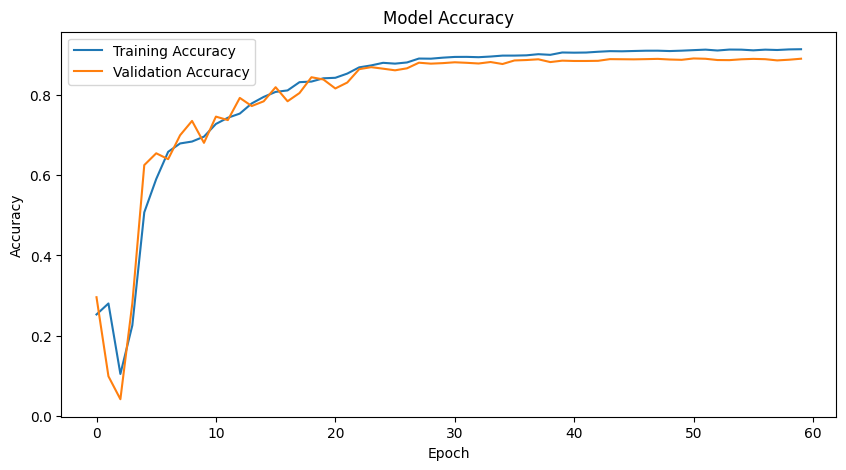

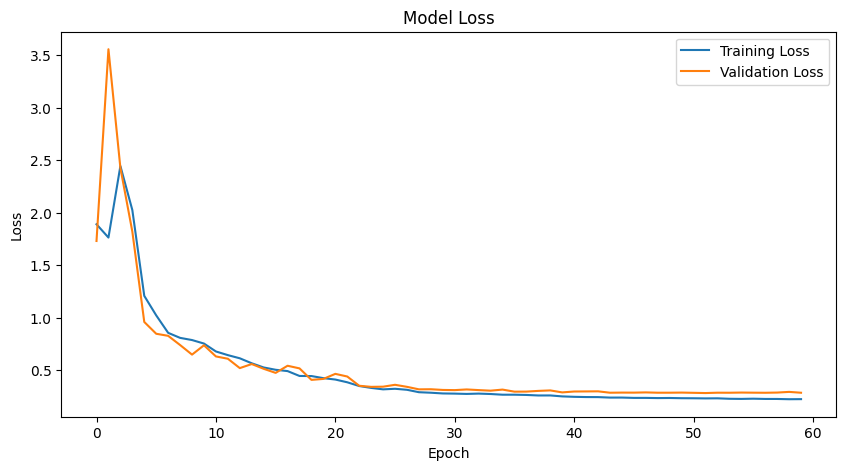

In [4]:
import matplotlib.pyplot as plt
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
from sklearn.metrics import classification_report
# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=modTypes))

240/240 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step

Classification Report:
              precision    recall  f1-score   support

        BPSK       0.87      0.78      0.83       773
        QPSK       0.66      0.76      0.71       761
        8PSK       0.77      0.75      0.76       751
       16QAM       0.89      0.76      0.82       724
       64QAM       0.86      0.96      0.91       794
        GFSK       0.98      0.98      0.98       737
       CPFSK       0.99      0.99      0.99       741
        PAM4       1.00      1.00      1.00       733
        B-FM       0.99      0.98      0.98       747
      DSB-AM       0.99      1.00      1.00       344
      SSB-AM       0.95      0.97      0.96       553

    accuracy                           0.89      7658
   macro avg       0.90      0.90      0.90      7658
weighted avg       0.90      0.89      0.89      7658



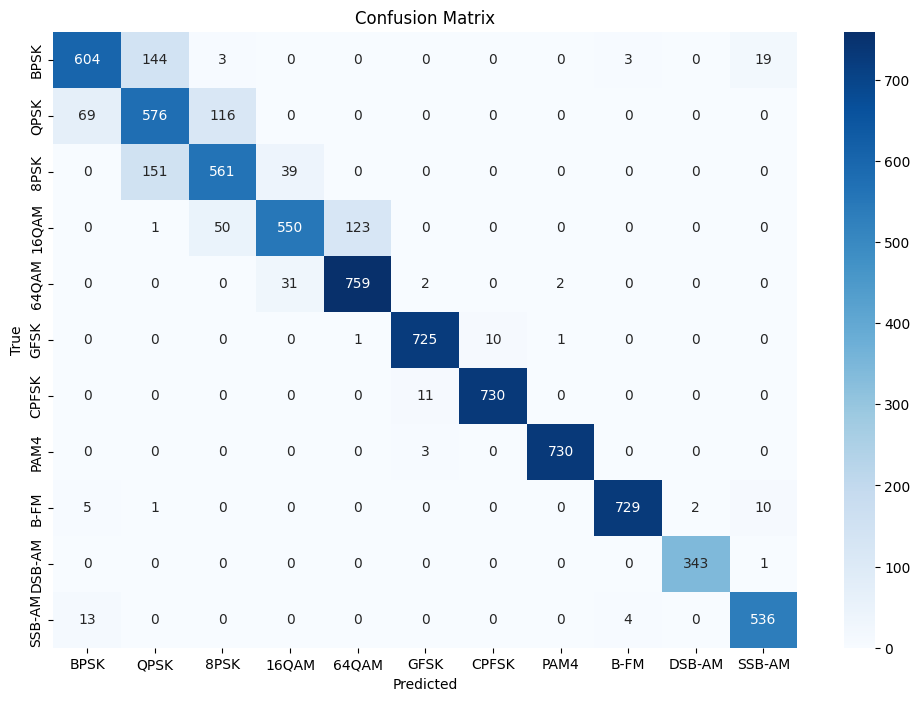

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=modTypes, yticklabels=modTypes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()